In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [2]:
my_tf = 'Rara'

infile_chip = f'../results/mm10/Chip_tensors/Window_pm5kb_bin_size_10/{my_tf}.hdf5'
infile_peak = f'../results/mm10/Peak_tensors/Window_pm5kb/{my_tf}.hdf5'
window_kb = 5
bin_size = 10

# get chip signal
with h5py.File(infile_chip,'r') as hf:
    X = hf['chip_prom_pos_exp'][:]

# reshape: concatenate all promoter together
N_prom, N_pos, N_exp = X.shape
X_prom = X.copy()
X = X.reshape([N_prom*N_pos,N_exp])

# get peaks
with h5py.File(infile_peak,'r') as hf:
    Peaks = hf['peak_prom_pos_exp'][:]

# bin peaks in args.bin_size bins
Peaks = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
Peaks_prom = Peaks.copy()

# reshape: concatenate all promoter together
Peaks = Peaks.reshape([N_prom*N_pos,N_exp])

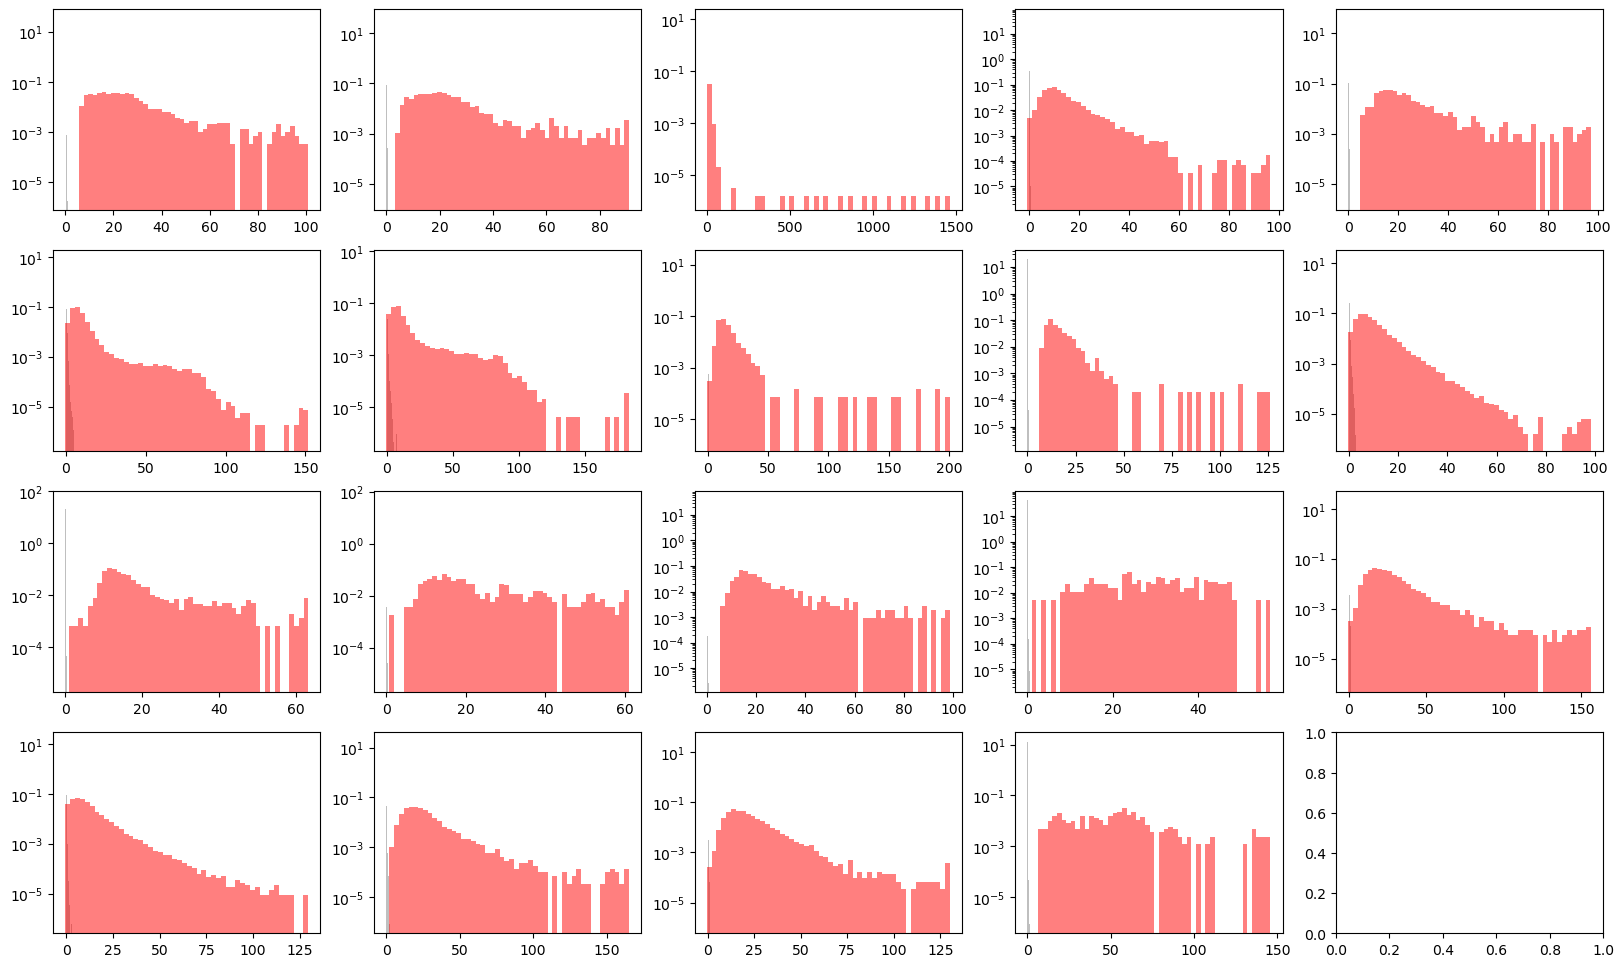

In [10]:
fig, axes = plt.subplots(4,5,figsize=(20,12))
X[np.isnan(X)] = 0

for i in range(N_exp):
    x_bg = X[(~Peaks[:,i]) & (~np.isnan(X[:,i])),i]
    x_fg = (X[Peaks[:,i],i] - x_bg.mean() )/ x_bg.std()

    min_bg = x_bg.min()
    mu_bg = x_bg.mean()
    std_bg = x_bg.std()

    #x_bg = np.exp(x_bg)
    #x_fg = np.exp(x_fg)
    
    ax = axes.flatten()[i]
    _ = ax.hist(x_bg, bins=50, density=True, alpha=0.5, color='gray')
    _ = ax.hist(x_fg, bins=50, density=True, alpha=0.5, color='red')

    ax.set_yscale('log')

In [14]:
# get chip signal
with h5py.File(infile_chip,'r') as hf:
    X = hf['chip_prom_pos_exp'][:]

# reshape: concatenate all promoter together
N_prom, N_pos, N_exp = X.shape
X_prom = X.copy()
X = X.reshape([N_prom*N_pos,N_exp])

# get peaks
with h5py.File(infile_peak,'r') as hf:
    Peaks = hf['peak_prom_pos_exp'][:]

# bin peaks in args.bin_size bins
Peaks = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)
Peaks_prom = Peaks.copy()

# reshape: concatenate all promoter together
Peaks = Peaks.reshape([N_prom*N_pos,N_exp])

# normalize as z score (w.r.t. BG) in log-space
if False:
    for i in range(N_exp):

        idx_peak = Peaks[:,i]
        idx_nan = np.isnan(X[:,i])

        # get background: signal in non-peak & non-nan regions
        x_bg = np.log( X[(~idx_peak) & (~idx_nan),i] )
        mu = x_bg.mean()
        std = x_bg.std()

        # replace non-nan signal with normalized signal
        X[~idx_nan,i] = (np.log( X[~idx_nan,i] ) - mu)/std
        X[idx_nan,i] = np.mean(X[idx_nan,i])

# put nan to 0    
X[np.isnan(X)] = 0

idx_svd = np.where((Peaks.sum(axis=1)>0))[0] # at least 1 peak

if len(idx_svd) == 0:
    idx_svd = (X > X.mean(0) + 3*X.std(0)).any(1)

# SVD
U_peak,S,Vh = np.linalg.svd(X[idx_svd,:],full_matrices=False)

# change sign such that sum(U,0) > 0
sign = np.sign(U_peak.sum(axis=0,keepdims=True))
U_peak = sign*U_peak
Vh = sign.T*Vh

U = X @ Vh.T @ np.diag(1/S)
U = U / np.linalg.norm(U,axis=0,keepdims=True)

<BarContainer object of 19 artists>

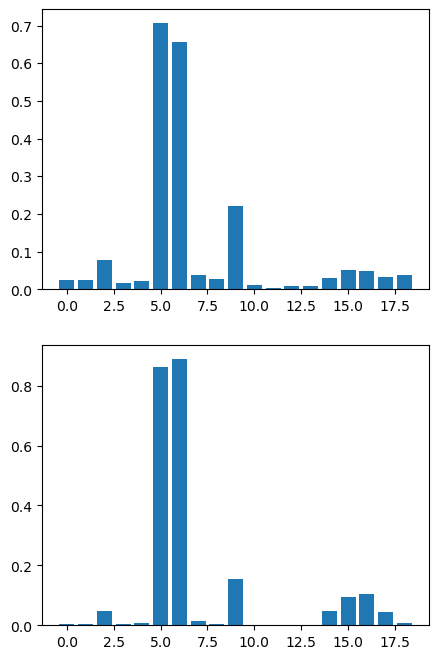

In [15]:
fig, axes = plt.subplots(2,1,figsize=(5,8))

ax = axes[0]
ax.bar(range(Vh.shape[1]),height=Vh[0,:])

ax = axes[1]
v = np.var(X[idx_svd,:],axis=0)
ax.bar(range(v.shape[0]),height=v)



Eapp
Rbks
Hivep3
Tomm5
Tex14
Fubp3
Plekhb1
Oxnad1
Dph3
Mtf2
Rarb
Cdx1
Cdk15
Mkrn1
Sspn
Rps29


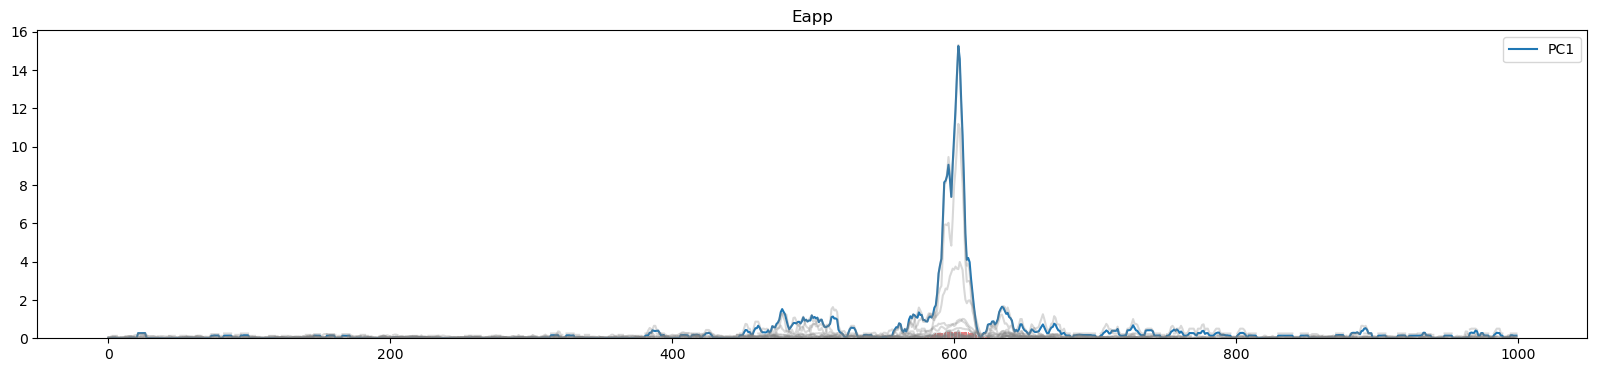

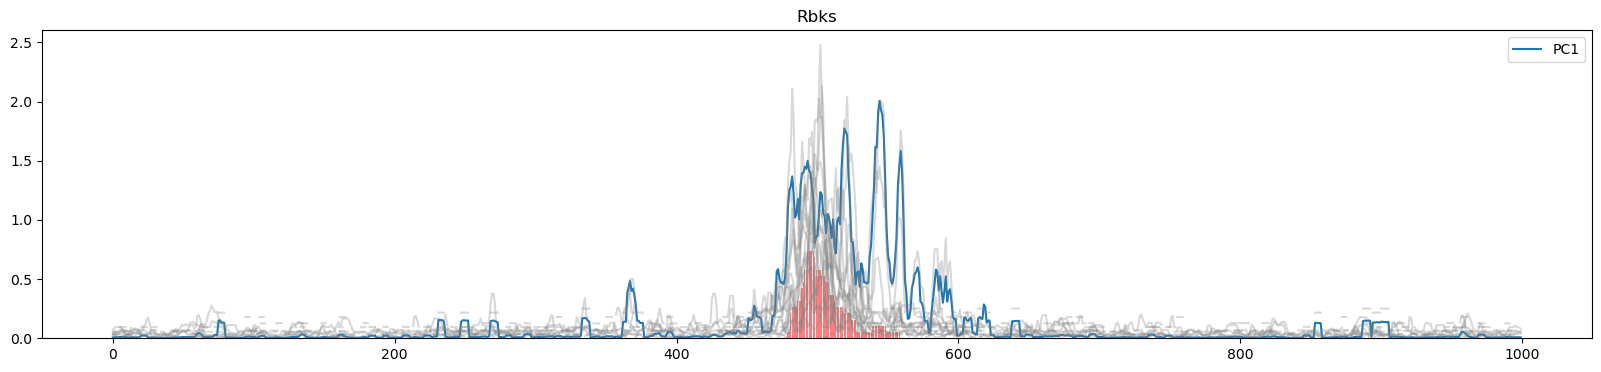

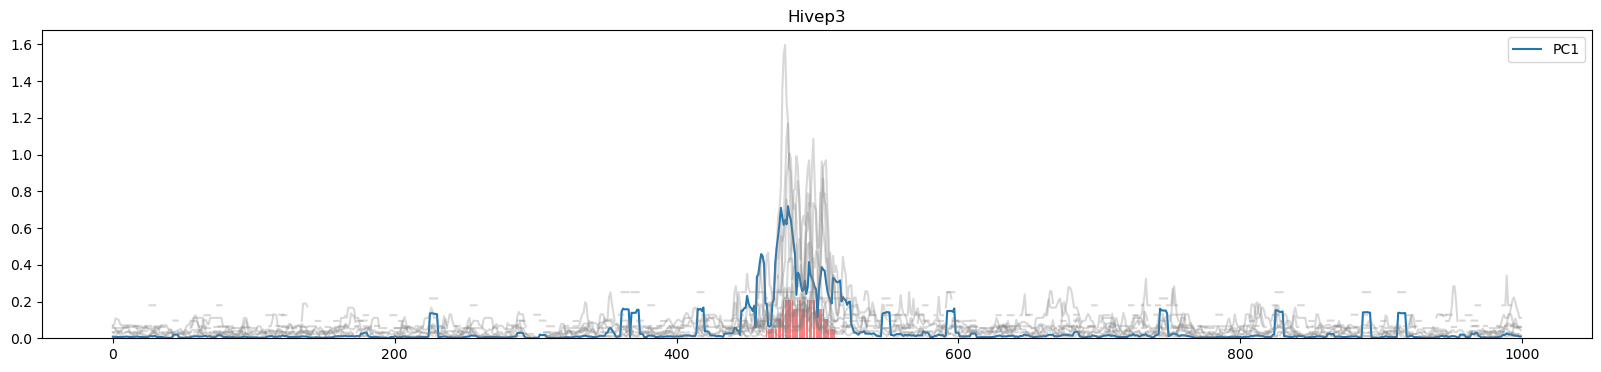

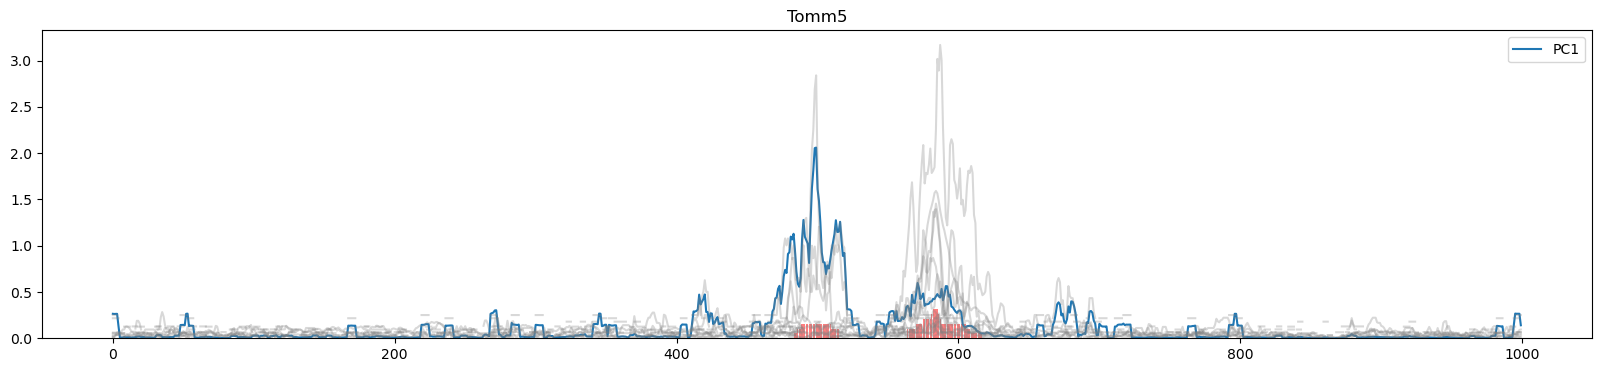

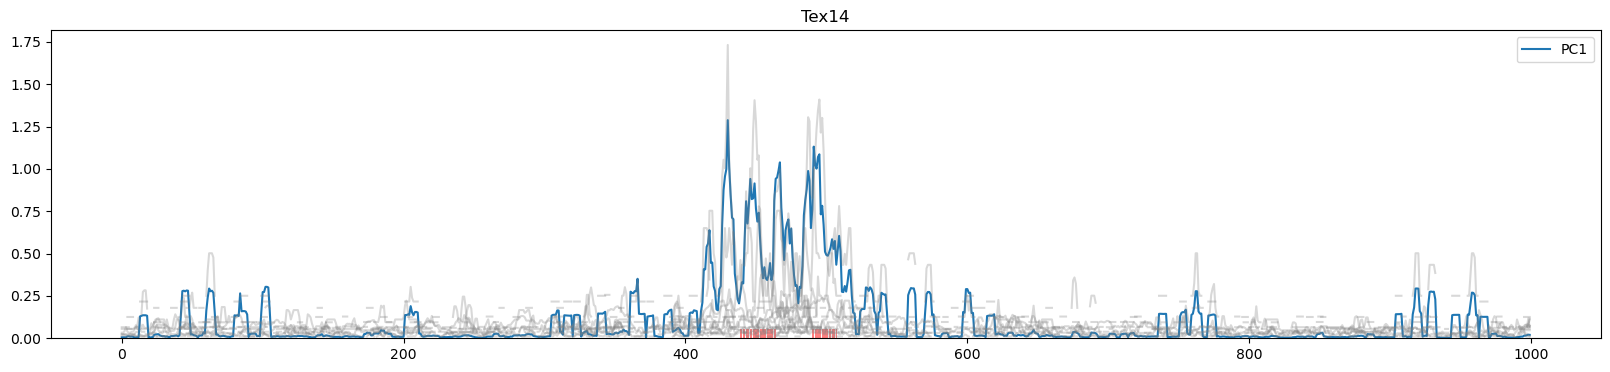

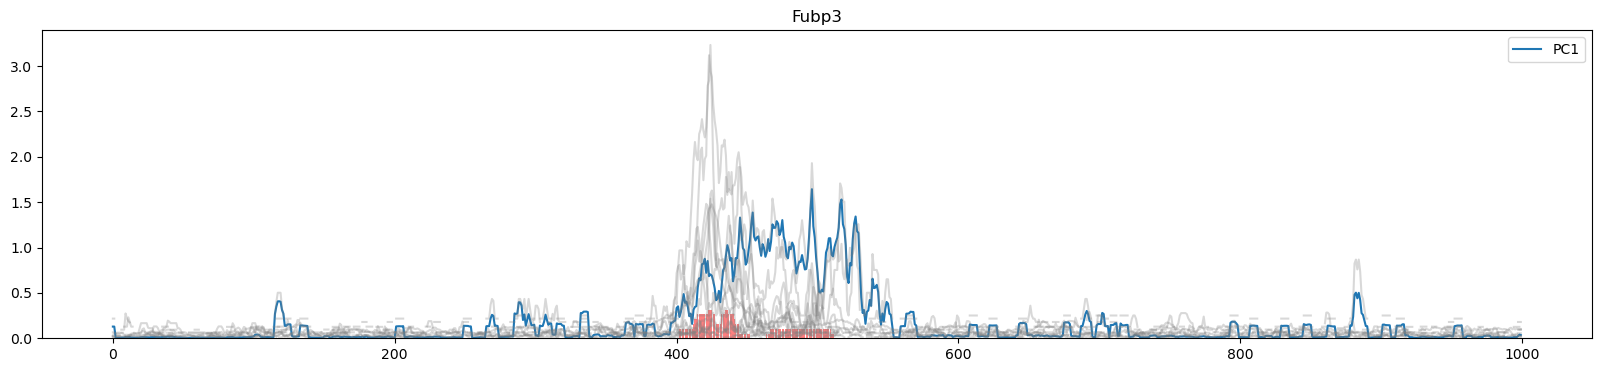

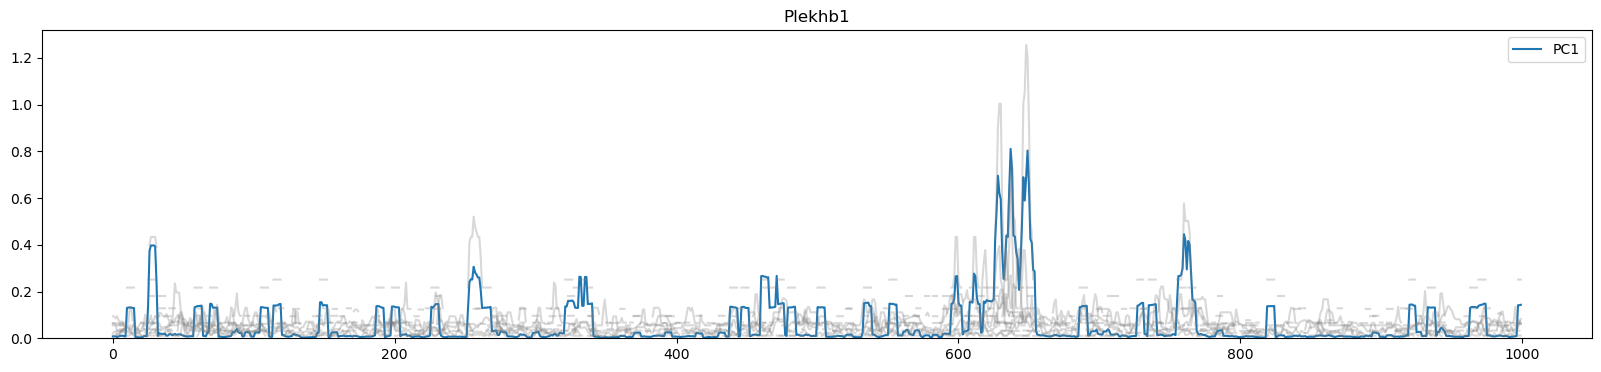

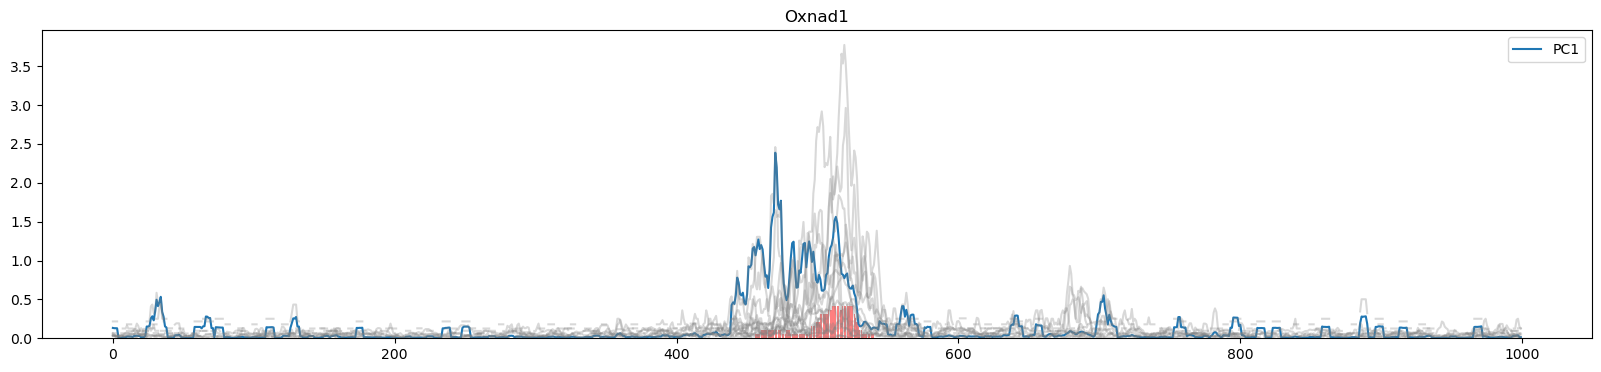

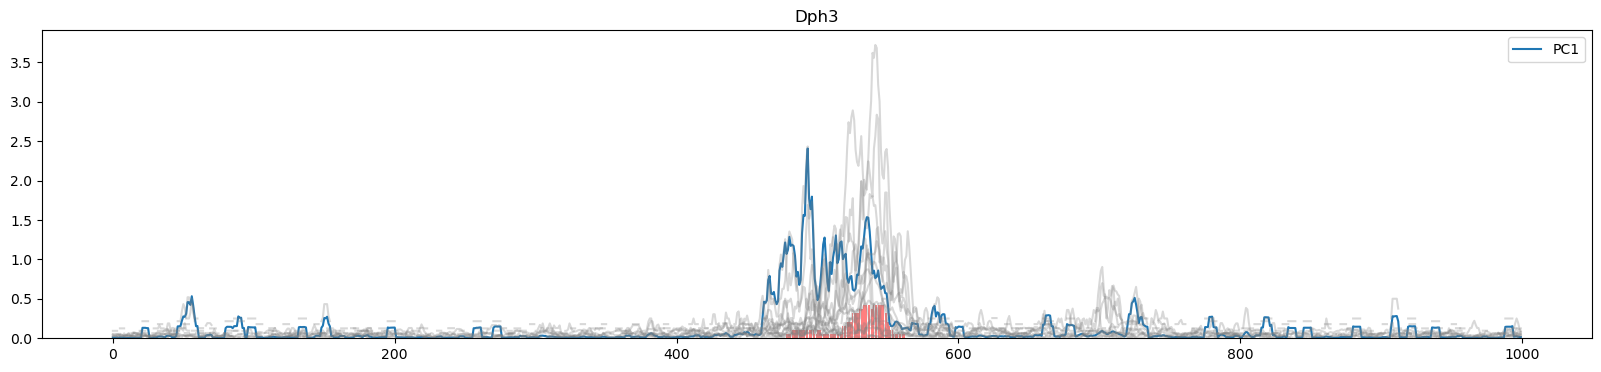

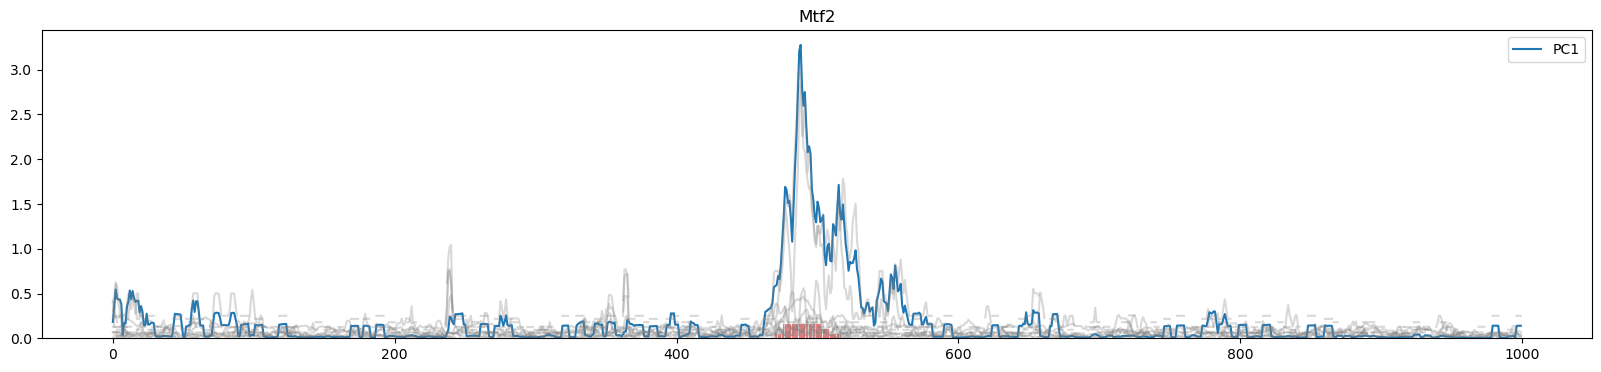

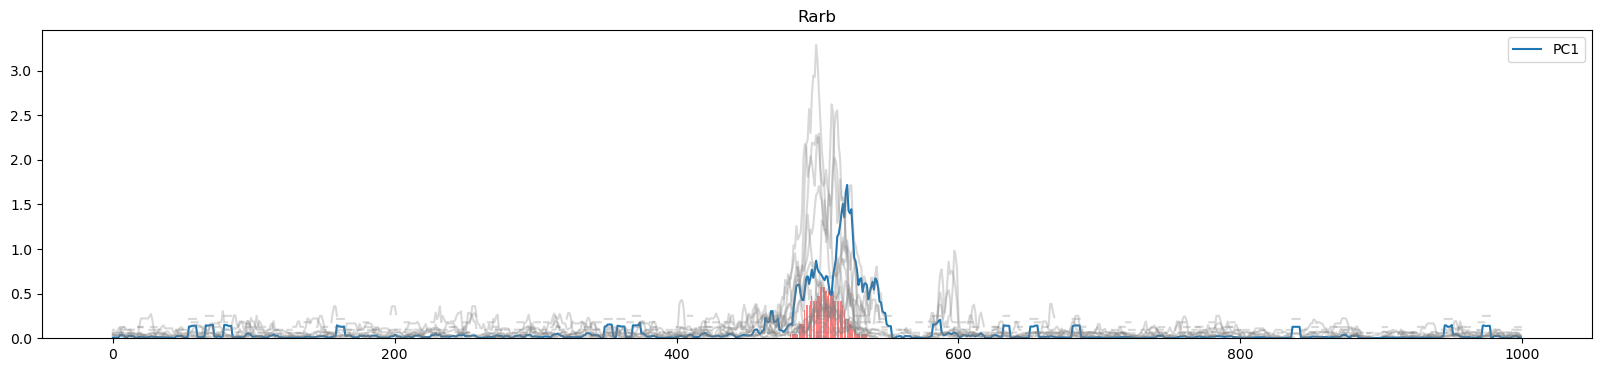

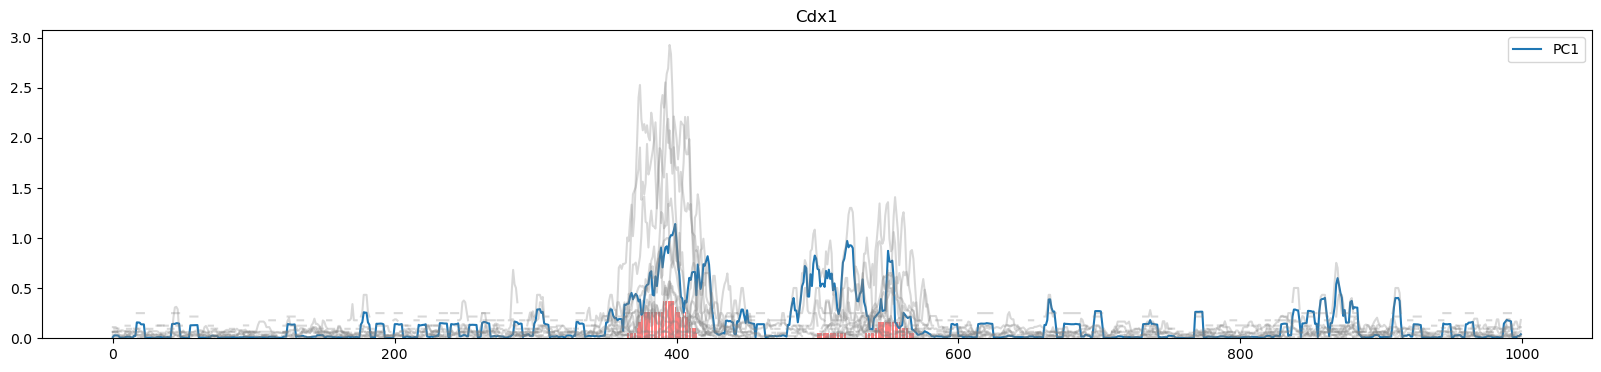

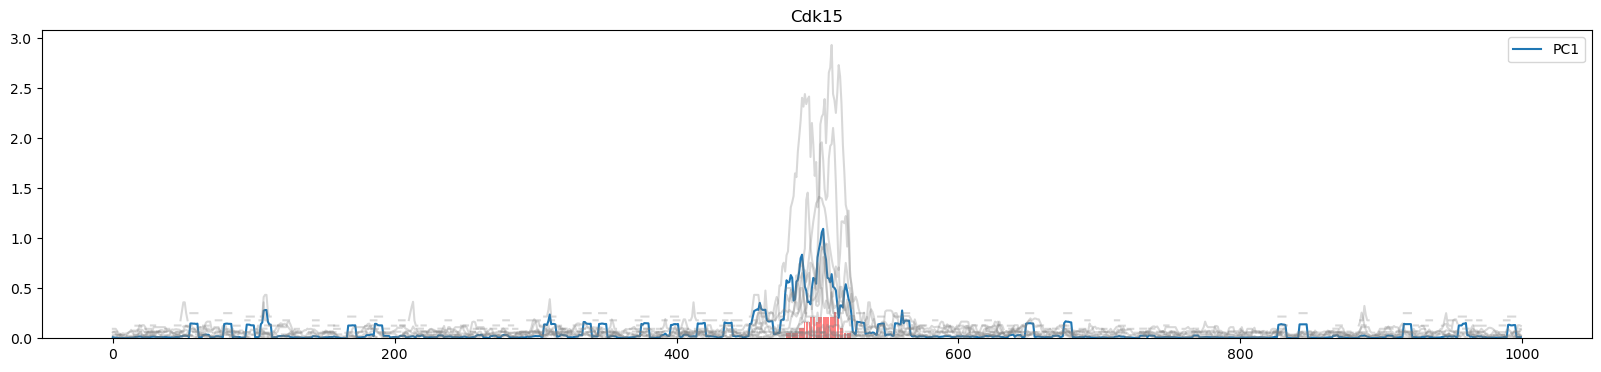

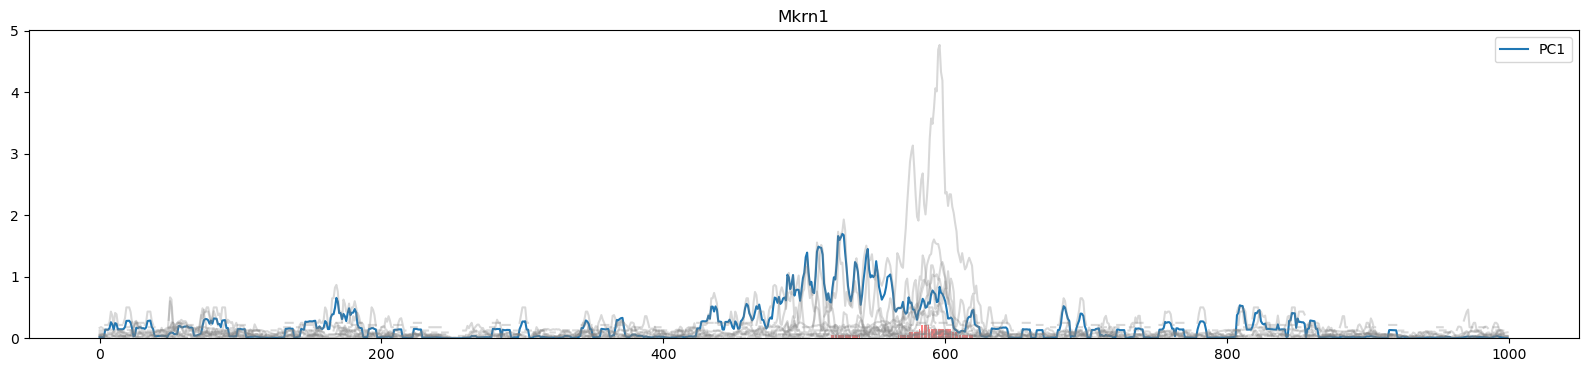

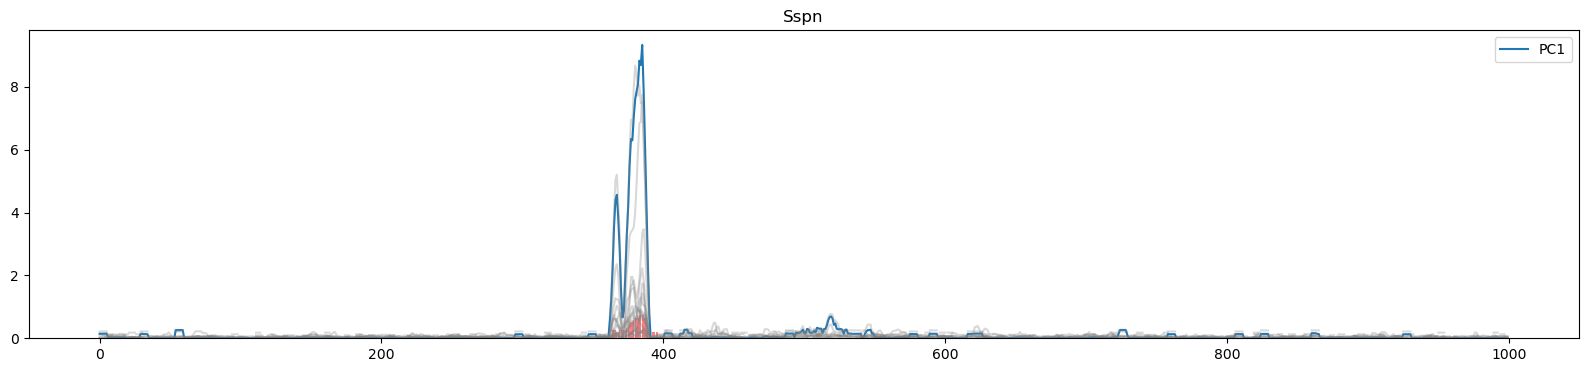

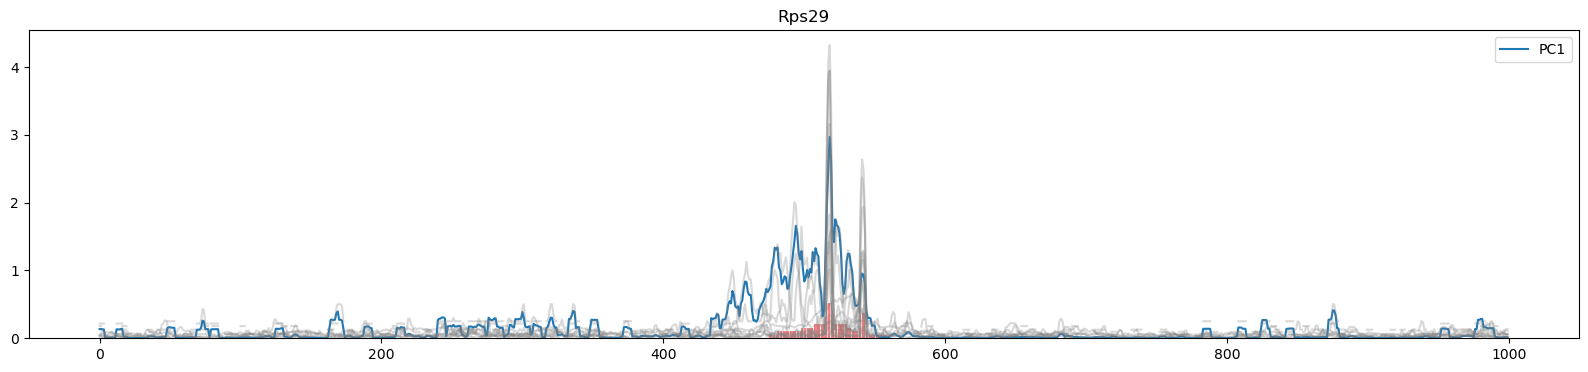

In [16]:
promoterome = pd.read_csv('~/Promoterome/results/mm10/promoterome_pm5kb_filtered_clustered_sorted.bed',sep='\t')

my_targets = ['Oasl1','Eapp','Adgra2','Rbks','Babam2','Asmt','Hivep3','Tomm5','Tex14','H4c8','Fubp3','Plekhb1','H4c3','Oxnad1','Dph3','Mtf2','Rarb','Cdx1','Cdk15','Mkrn1','Sspn','Rps29']

for g in my_targets:
    if g not in promoterome['gene'].values:
        continue

    print(g)
    p = promoterome[promoterome['gene'] == g]
    idx_p = p.index[0]

    fig, ax = plt.subplots(1,1,figsize=(20,4))

    for pc in range(1):
        u = U[:,pc].reshape([N_prom,N_pos])
        ax.plot(u[idx_p,:]*S[pc],label=f'PC{pc+1}')
    ax.legend()

    ax.plot(X_prom[idx_p],color='gray',alpha=0.3)
    ax.bar(range(1000),Peaks_prom[idx_p].mean(1),color='red',alpha=0.5)

    ax.set_title(g)

In [30]:
U[:,0]

(24424000, 19)

In [47]:
np.isnan(X).sum(0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])